In [ ]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2

import os
path_parent = os.path.dirname(os.getcwd())

if os.getcwd()[-8:] != 'FYP-Code':
    os.chdir(path_parent)

print(os.getcwd())


import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-pastel')
plt.rcParams.update({'font.family': 'Times New Roman'})
plt.rcParams.update({'axes.grid': True, 'axes.linewidth': 0.5, 'axes.edgecolor': 'black'})


/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code


In [1]:
from analysis.gridbased import model

In [2]:
model_type = 'dense'
parameterization = 'svensson'
models = model.init_model(model_type = model_type, parameterization = parameterization)

Model: "dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  300       
                                                                 
 dense_1 (Dense)             multiple                  930       
                                                                 
 dense_2 (Dense)             multiple                  930       
                                                                 
 dense_3 (Dense)             multiple                  1953      
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
Total params: 4,113
Trainable params: 4,113
Non-trainable params: 0
_________________________________________________________________


In [3]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


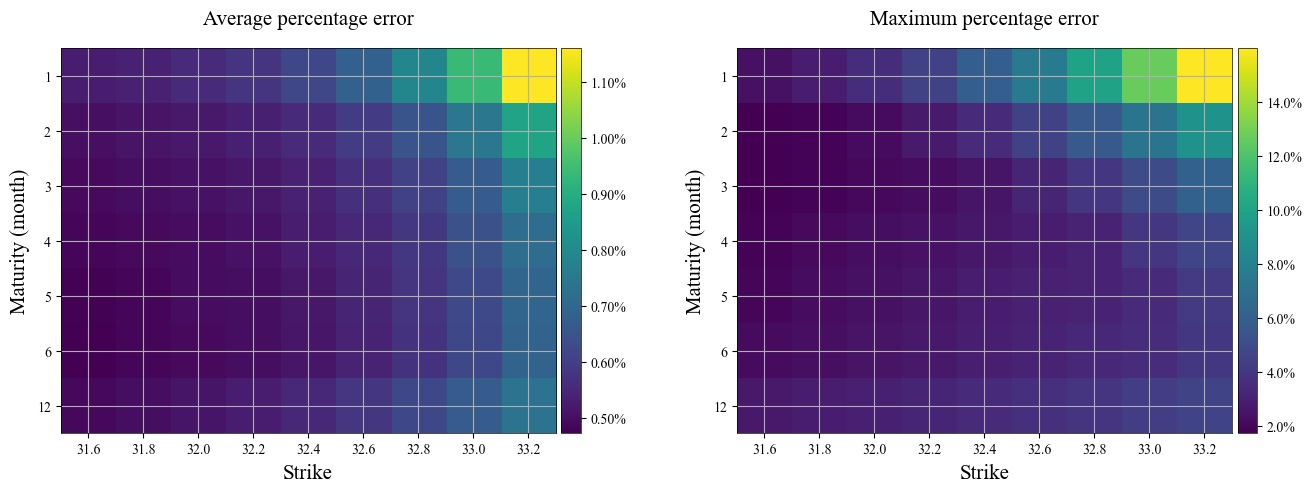

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
# print(os.getcwd())
model.train_model(models, epochs = 200, model_type = model_type, parameterization = parameterization)

In [5]:
model.load_weights(models, model_type = model_type, parameterization = parameterization)

In [6]:
params_range_train, params_range_test, price_train, price_test = model.load_data(parameterization = parameterization)

In [ ]:
model.calibrate(model = models, prices = price_test, parameters = params_range_test, epochs = 200, model_type = model_type, parameterization = parameterization, plot = True)

100%|██████████| 200/200 [00:01<00:00, 182.57it/s]


In [8]:
params_range_test.shape

(4000, 9)

In [ ]:
from helper.synthesis import create_features_linspace
%load_ext autoreload
%autoreload 2


In [9]:
from analysis.pointwise import model as pointwise_model

In [10]:
import os
os.getcwd()

'/Users/samaypanwar/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/Uni/FYP/FYP-Code'

In [32]:
parameterization = 'svensson'
pointwise_models = pointwise_model.init_model(model_type = 'dense', parameterization = parameterization)

Model: "dense_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             multiple                  360       
                                                                 
 dense_9 (Dense)             multiple                  930       
                                                                 
 dense_10 (Dense)            multiple                  930       
                                                                 
 dense_11 (Dense)            multiple                  31        
                                                                 
Total params: 2,251
Trainable params: 2,251
Non-trainable params: 0
_________________________________________________________________


100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


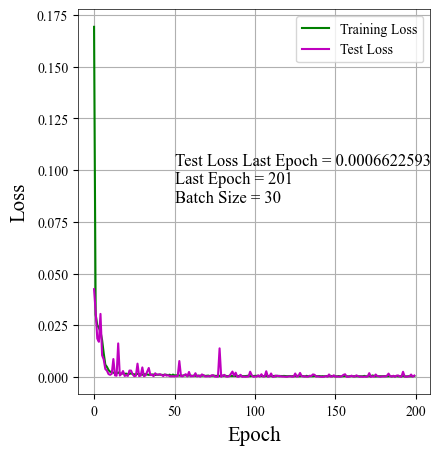

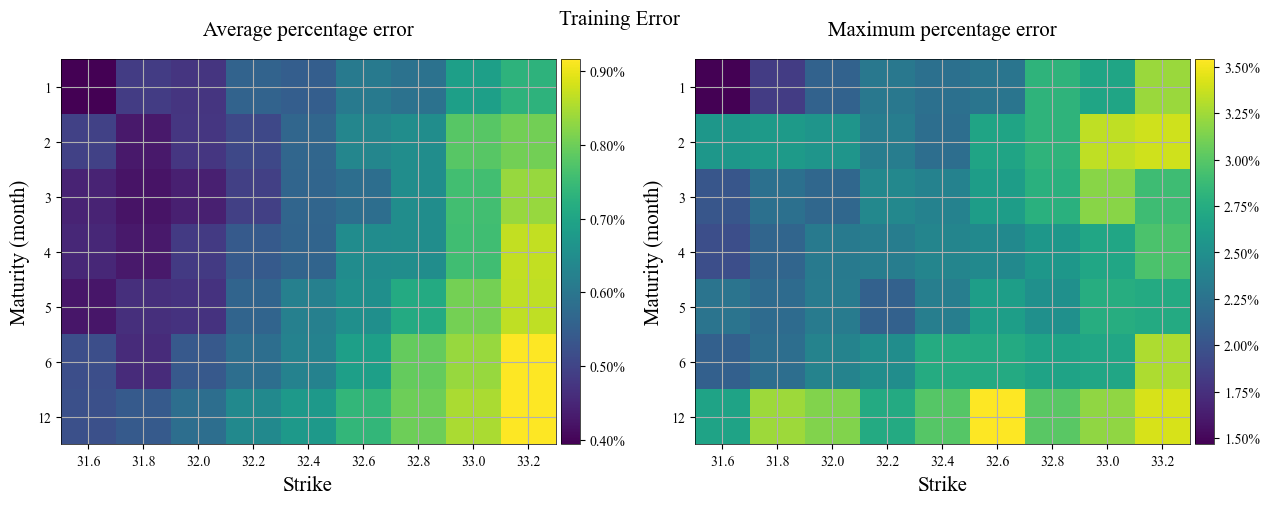

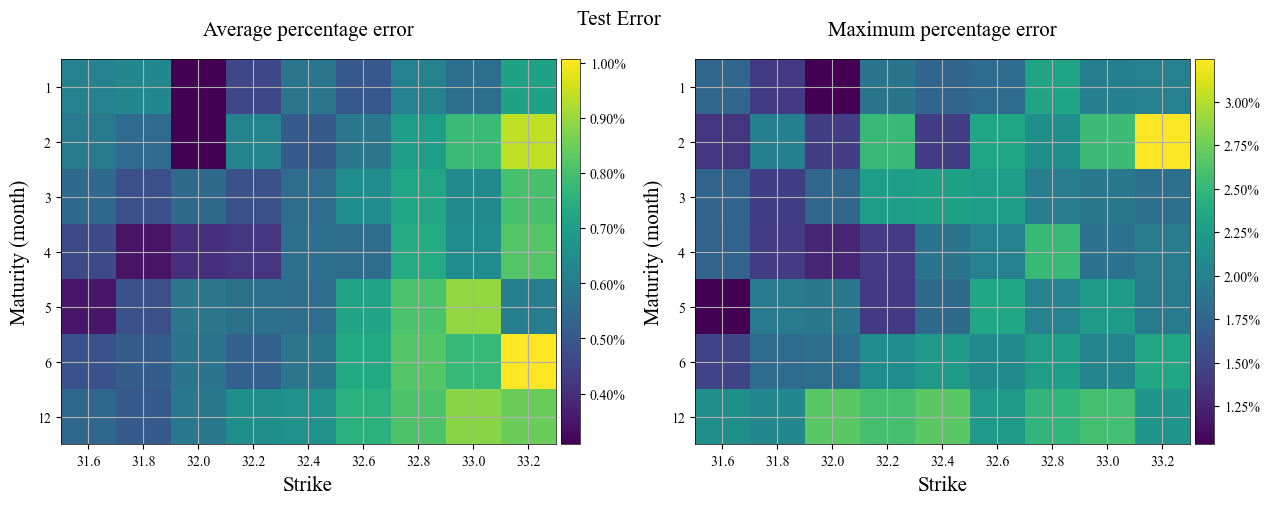

In [33]:
pointwise_model.train_model(pointwise_models, epochs = 200, model_type = 'dense', parameterization = parameterization)

In [34]:
pointwise_model.load_weights(pointwise_models, parameterization = parameterization)
params_range_train, params_range_test, price_train, price_test = pointwise_model.load_data(parameterization = parameterization)

100%|██████████| 4000/4000 [12:33<00:00,  5.31it/s]


[[32.69824314  0.90295613  0.30822064 ...  4.66108321  1.37697448
   1.09212709]
 [31.82800518  0.23262839  0.38731335 ...  4.51764813  0.9218505
   0.90485011]
 [32.7528262   0.37186072  0.20745926 ...  4.71092525  0.63888952
   0.5698425 ]
 ...
 [31.71611173  0.72107699  0.45932862 ...  4.9986136   1.22481193
   0.93814632]
 [32.18874065  0.32394297  0.47986545 ...  4.98310189  1.02805746
   1.4148617 ]
 [32.97741312  0.75247354  0.4744176  ...  4.93463488  0.61754813
   1.13440078]]


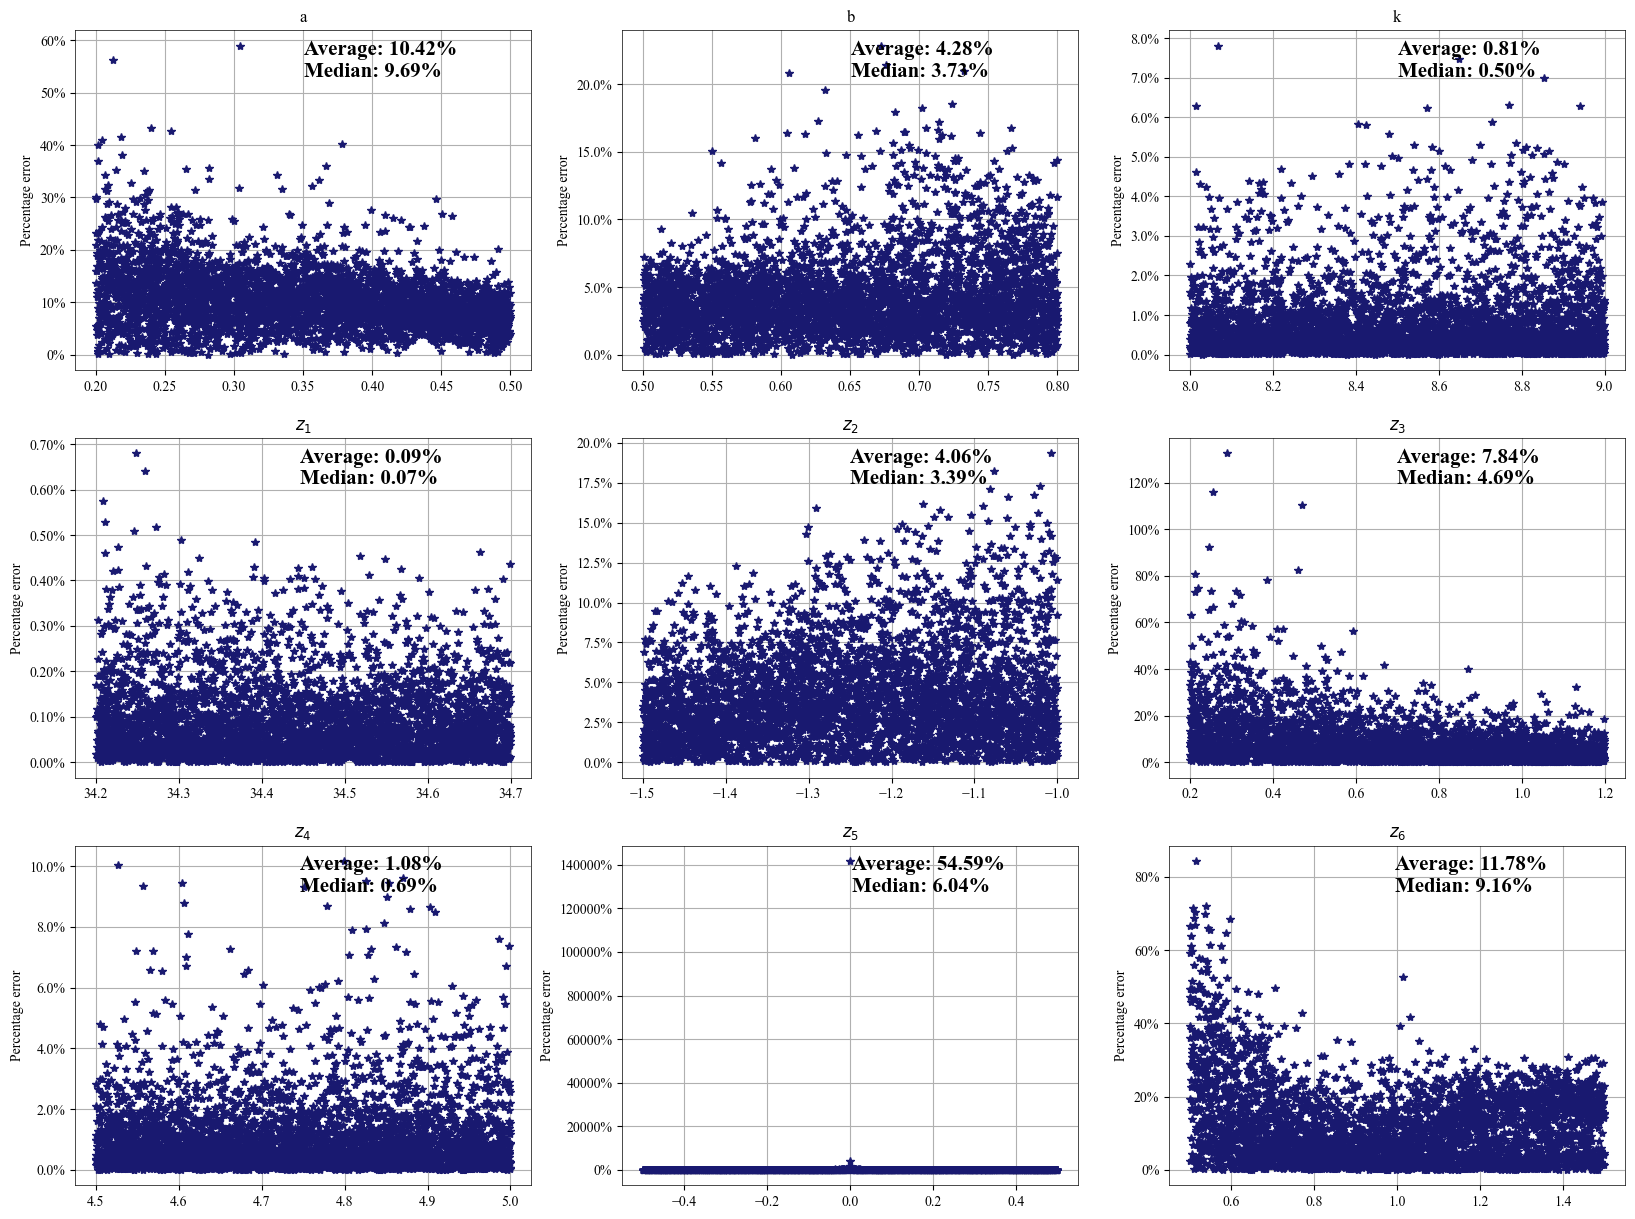

In [36]:
pointwise_model.calibrate(model = pointwise_models, prices = price_test, parameters = params_range_test, parameterization = parameterization, plot = True, epochs = 200
                )

In [38]:
params_range_train.shape

(40000, 11)

In [ ]:
from helper.parameterizations import SvenssonCurve

In [ ]:
sc = SvenssonCurve(parameters = [6.6, -5, -100, 10, -0.5, 1])

In [ ]:
sc.calculate_average_integral_curve(0, 3)

In [ ]:
y = []
import numpy as np
x = np.linspace(0, 1, 1001)
for i in x:
  y.append(sc(i))

import matplotlib.pyplot as plt

plt.plot(x, y)

In [ ]:
from helper.synthesis import generate_grid_data, generate_pointwise_data

In [ ]:
generate_grid_data(parameterization = 'svensson')

In [ ]:
generate_pointwise_data(parameterization = 'svensson')